In [28]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [29]:
# Using seaborn for pairplot.
!pip install -q seaborn
!pip install -q tensorflow

In [47]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.models import Sequential

In [31]:
# Load the CSV file
df = pd.read_csv('../Next_Generation_Simulation__NGSIM__Vehicle_Trajectories_and_Supporting_Data_20240819.csv')

# Select the required columns
required_columns = ['Global_X', 'Global_Y', 'v_Vel', 'v_Acc', 'Global_Time', 'Vehicle_ID']
velocity_dataset = df[required_columns]

In [32]:
velocity_dataset.shape

(9455901, 6)

In [33]:
# Sort by Vehicle_ID and Global_Time
velocity_dataset_sorted = velocity_dataset.sort_values(by=['Vehicle_ID', 'Global_Time']).reset_index(drop=True)

In [34]:
velocity_dataset_sorted

,Global_X,Global_Y,v_Vel,v_Acc,Global_Time,Vehicle_ID
0,6042841.908,2133120.155,12.50,0.00,1113433136300,1
1,6042839.670,2133135.799,14.64,0.08,1113433137500,1
2,6042839.214,2133138.665,14.59,-0.54,1113433137700,1
3,6042838.525,2133142.971,14.13,-3.49,1113433138000,1
4,6042837.417,2133153.456,13.00,0.00,1113433138800,1
...,...,...,...,...,...,...
9455896,6042608.928,2134671.977,63.93,-11.20,1113433457400,3366
9455897,6042607.952,2134678.398,62.22,-11.20,1113433457500,3366
9455898,6042606.994,2134684.573,62.22,0.00,1113433457600,3366
9455899,6042606.083,2134690.504,62.22,0.00,1113433457700,3366


In [35]:
# Extract unique Vehicle_IDs and count them
unique_vehicle_ids = velocity_dataset_sorted['Vehicle_ID'].unique()
num_unique_ids = len(unique_vehicle_ids)
print(f"Number of unique Vehicle_IDs: {num_unique_ids}")

Number of unique Vehicle_IDs: 3233


In [36]:
# Function to convert a series to a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    df_s = pd.DataFrame(data)
    cols, names = [], []
    
    # Input sequence (t-n, ..., t-1)
    for i in range(n_in, 0, -1):
        cols.append(df_s.shift(i))
        names.append(f'var1(t-{i})')
    
    # Forecast sequence (t)
    for i in range(0, n_out):
        cols.append(df_s.shift(-i))
        names.append(f'var1(t+{i})')
    
    # Combine all
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [37]:
# Convert to supervised learning problem
n_in = 8  # Number of previous time steps as input
n_out = 1  # Predict one step ahead

In [38]:
# Initialize an empty list to store the converted datasets
all_supervised_data = []

# Initialize a dictionary to store the counts
vehicle_id_counts = {}

# Loop through each unique Vehicle_ID
for vehicle_id in unique_vehicle_ids:
    # Filter data for the specific Vehicle_ID
    single_vehicle_data = velocity_dataset_sorted[velocity_dataset_sorted['Vehicle_ID'] == vehicle_id]
    
    # Extract the velocity column (you can include other columns if needed)
    velocities = single_vehicle_data['v_Vel'].values
    
    # Store the count of velocity data for the current Vehicle_ID
    vehicle_id_counts[vehicle_id] = len(velocities)
    
    # Convert to supervised learning problem
    supervised_data = series_to_supervised(velocities, n_in=n_in, n_out=n_out)
    
    # Add a column for Vehicle_ID to track which data belongs to which vehicle
    supervised_data['Vehicle_ID'] = vehicle_id
    
    # Append the converted data to the list
    all_supervised_data.append(supervised_data)

# Combine all supervised data into a single DataFrame
final_supervised_dataset = pd.concat(all_supervised_data, axis=0, ignore_index=True)

# Convert the vehicle_id_counts dictionary into a DataFrame for easier inspection or saving
vehicle_id_counts_df = pd.DataFrame(list(vehicle_id_counts.items()), columns=['Vehicle_ID', 'Velocity_Count'])

# Save or inspect the dataset
print(final_supervised_dataset.head())

   var1(t-8)  var1(t-7)  var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  \
0      12.50      14.64      14.59      14.13      13.00      13.00   
1      14.64      14.59      14.13      13.00      13.00      13.00   
2      14.59      14.13      13.00      13.00      13.00      12.99   
3      14.13      13.00      13.00      13.00      12.99       3.96   
4      13.00      13.00      13.00      12.99       3.96       3.67   

   var1(t-2)  var1(t-1)  var1(t+0)  Vehicle_ID  
0      13.00      12.99       3.96           1  
1      12.99       3.96       3.67           1  
2       3.96       3.67       3.67           1  
3       3.67       3.67       3.68           1  
4       3.67       3.68       3.64           1  


In [39]:
vehicle_id_counts_df.to_csv('vehicle_id_velocity_counts.csv', index=False)
print(vehicle_id_counts_df.head(10).to_string(index=False))

 Vehicle_ID  Velocity_Count
          1            1196
          2            4565
          3            1731
          4            2503
          5            3622
          6            1961
          7            1676
          8            2048
          9            3824
         10            3661


In [40]:
# Split the supervised data into training, validation, and test sets
n_train = int(len(final_supervised_dataset) * 0.7)
n_validation = int(len(final_supervised_dataset) * 0.15)

train_data = final_supervised_dataset[:n_train]
validation_data = final_supervised_dataset[n_train:n_train + n_validation]
test_data = final_supervised_dataset[n_train + n_validation:]

# Separate inputs (X) and outputs (y)
# Assuming the last column is 'Vehicle_ID' and the second-to-last column is the target (var1(t+0))
X_train, y_train = train_data.iloc[:, :-2].values, train_data.iloc[:, -2].values
X_validation, y_validation = validation_data.iloc[:, :-2].values, validation_data.iloc[:, -2].values
X_test, y_test = test_data.iloc[:, :-2].values, test_data.iloc[:, -2].values

In [41]:
# Reshape data for LSTM (samples, time steps, features)
# '-1' lets it automatically match the number of features(more generic), can put '1' when working with just one variable v_Vel
X_train = X_train.reshape((X_train.shape[0], n_in, -1))
X_validation = X_validation.reshape((X_validation.shape[0], n_in, -1))
X_test = X_test.reshape((X_test.shape[0], n_in, -1))

In [42]:
print(X_test.shape)
print(y_test.shape)

(1414506, 8, 1)
(1414506,)


In [43]:
# Define subset sizes
train_subset_size = 50000  # Adjust based on available data
val_subset_size = 10000     # Adjust based on available data

# Create smaller subsets
small_X_train = X_train[:train_subset_size]
small_y_train = y_train[:train_subset_size]
small_X_validation = X_validation[:val_subset_size]
small_y_validation = y_validation[:val_subset_size]

In [44]:
# # Define the LSTM model
# lstm_model = tf.keras.Sequential([
#     tf.keras.layers.LSTM(256, activation='relu', input_shape=(X_train.shape[1], 1), 
#                            return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
#     tf.keras.layers.LSTM(128, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
#     tf.keras.layers.LSTM(64, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
#     tf.keras.layers.LSTM(64, activation='relu', return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
#     tf.keras.layers.LSTM(64, activation='relu', return_sequences=False, dropout=0.2, recurrent_dropout=0.2),
#     tf.keras.layers.Dense(1)
# ]

In [48]:
# Define the Uni and Bidirectional LSTM model
lstm_model = Sequential([
    # First layer: Bidirectional LSTM to capture context from both directions
    Bidirectional(LSTM(128, activation='relu', return_sequences=True), 
                  input_shape=(X_train.shape[1], X_train.shape[2])),
    # Second layer: Another Bidirectional LSTM
    Bidirectional(LSTM(64, activation='relu', return_sequences=True)),
    # Third & Fourth layer: Unidirectional LSTM for further processing
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    # Final Dense layer for prediction
    Dense(1)
])

In [49]:
lstm_model.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model using the **smaller subsets**
history = lstm_model.fit(small_X_train, small_y_train, epochs=20, batch_size=32, 
                         validation_data=(small_X_validation, small_y_validation), 
                         verbose=1, callbacks=[early_stopping])

# Evaluate the model on the full test set
test_loss = lstm_model.evaluate(X_test, y_test, batch_size=64, verbose=1)  
print(f"Test Loss: {test_loss}")

# Compute RMSE
rmse = np.sqrt(test_loss)
print(f"RMSE on the test set: {rmse:.4f}")

Epoch 1/50
1563/1563 [==============================] - 123s 74ms/step - loss: 15.9974 - val_loss: 4.7566
Epoch 2/50
1563/1563 [==============================] - 115s 74ms/step - loss: 8.2868 - val_loss: 2.7889
Epoch 3/50
1563/1563 [==============================] - 116s 74ms/step - loss: 7.0106 - val_loss: 4.1635
Epoch 4/50
1563/1563 [==============================] - 118s 75ms/step - loss: 6.4320 - val_loss: 3.0746
Epoch 5/50
1563/1563 [==============================] - 117s 75ms/step - loss: 6.1391 - val_loss: 2.7563
Epoch 6/50
1563/1563 [==============================] - 117s 75ms/step - loss: 6.0694 - val_loss: 3.5424
Epoch 7/50
1563/1563 [==============================] - 118s 76ms/step - loss: 5.8339 - val_loss: 2.4988
Epoch 8/50
1563/1563 [==============================] - 118s 75ms/step - loss: 5.7642 - val_loss: 3.9762
Epoch 9/50
1563/1563 [==============================] - 125s 80ms/step - loss: 5.7551 - val_loss: 2.3931
Epoch 10/50
1563/1563 [==============================]

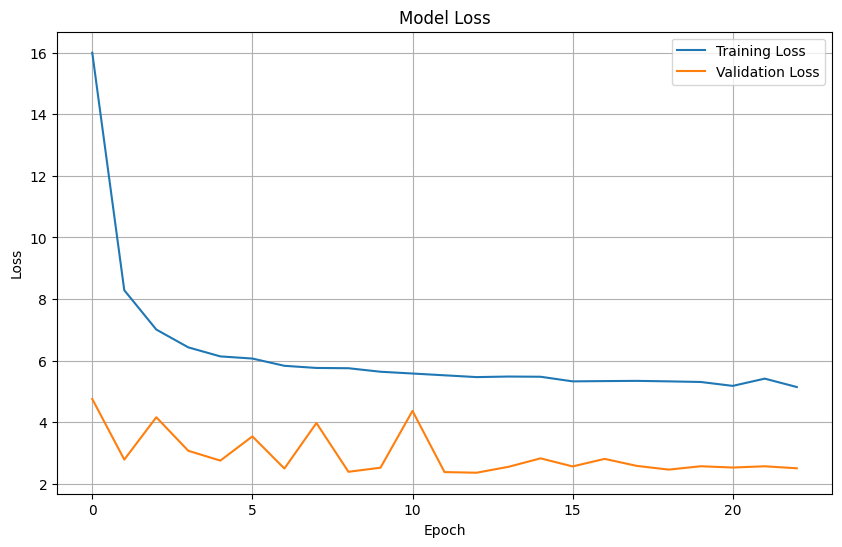

In [50]:
# Plotting training & validation loss curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history.get('val_loss'), label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [51]:
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("Model output shape (from summary):")
lstm_model.summary()

X_test shape: (1414506, 8, 1)
y_test shape: (1414506,)
Model output shape (from summary):
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 8, 256)            133120    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 8, 128)            164352    
 onal)                                                           
                                                                 
 lstm_7 (LSTM)               (None, 8, 32)             20608     
                                                                 
 lstm_8 (LSTM)               (None, 32)                8320      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                              

In [52]:
# Define the subset size (adjust as needed)
subset_size = 100

# Randomly select indices from the test set
random_indices = np.random.choice(len(X_test), size=subset_size, replace=False)

# Create the test subset using the selected indices
X_test_subset = X_test[random_indices]
y_test_subset = y_test[random_indices]

# Get predictions for the subset
predictions = lstm_model.predict(X_test_subset, verbose=1)

# Flatten the predictions if they come as a 2D array with shape (subset_size, 1)
predicted_values = predictions.flatten()

4/4 [==============================] - 1s 15ms/step


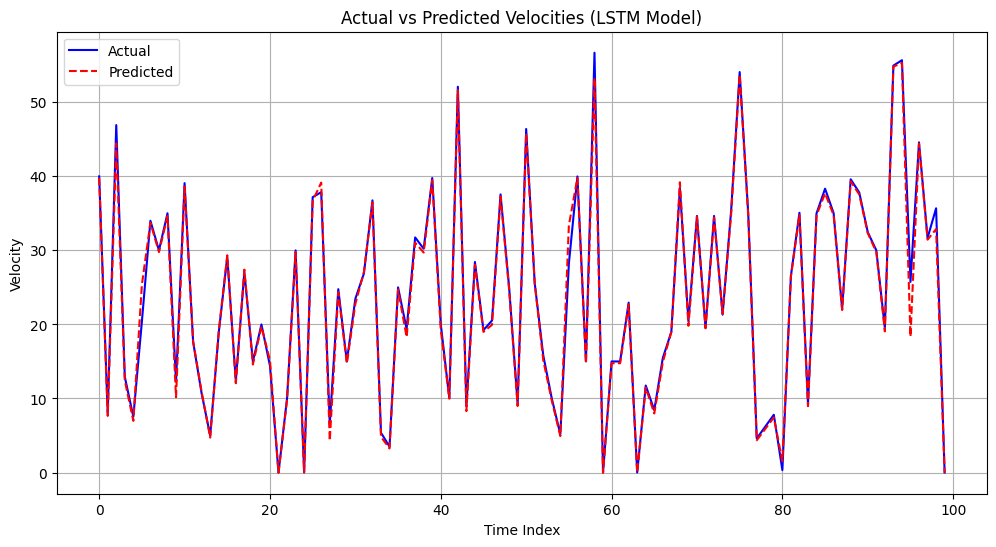

In [53]:
# Create time indices for plotting
time_indices = np.arange(len(y_test_subset))

# Create a DataFrame with actual and predicted values
results_df = pd.DataFrame({
    'Index': time_indices,
    'Actual': y_test_subset,
    'Predicted': predicted_values
})

# Plot the actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(results_df['Index'], results_df['Actual'], label='Actual', color='blue')
plt.plot(results_df['Index'], results_df['Predicted'], label='Predicted', color='red', linestyle='--')
plt.xlabel('Time Index')
plt.ylabel('Velocity')
plt.title('Actual vs Predicted Velocities (LSTM Model)')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
lstm_model.save("(uni+bi)lstm_(1.25MB).keras")